In [1]:
import os
import sys

import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Add project root to sys.path
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.config import TEST_DIR, FIGURES_DIR, MODELS_DIR
from src.utils.grad_cam import generate_gradcam_for_image
from src.utils.data_loader import create_dataloaders
from src.models.cnn_model import create_model

print("Project root:", PROJECT_ROOT)
print("Test dir:", TEST_DIR)
print("Models dir:", MODELS_DIR)
print("Figures dir:", FIGURES_DIR)
print("CUDA available:", torch.cuda.is_available())

Project root: D:\Projects\ivf-embryo-grading
Test dir: D:\Projects\ivf-embryo-grading\data\processed\test
Models dir: D:\Projects\ivf-embryo-grading\src\models
Figures dir: D:\Projects\ivf-embryo-grading\reports\figures
CUDA available: False


Sample image path: D:\Projects\ivf-embryo-grading\data\processed\test\high\0116_03.png
Predicted class: high


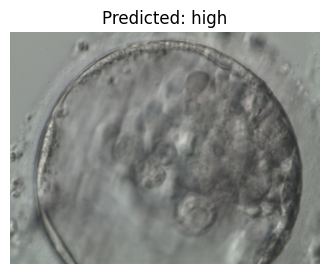

In [2]:
import glob

# Find a sample image from test set (first available)
sample_images = glob.glob(os.path.join(TEST_DIR, "**", "*.*"), recursive=True)
sample_images = [p for p in sample_images if p.lower().endswith((".png", ".jpg", ".jpeg"))]

if len(sample_images) == 0:
    raise RuntimeError("No test images found.")

sample_path = sample_images[0]
print("Sample image path:", sample_path)

# Load the model checkpoint
checkpoint_path = os.path.join(MODELS_DIR, "best_efficientnet_b0.pth")
checkpoint = torch.load(checkpoint_path, map_location="cpu")

model_name = checkpoint["model_name"]
class_to_idx = checkpoint["class_to_idx"]
idx_to_class = {v: k for k, v in class_to_idx.items()}

num_classes = len(class_to_idx)
model = create_model(model_name=model_name, num_classes=num_classes)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Preprocess sample image
from src.utils.grad_cam import preprocess_image

input_tensor, np_img = preprocess_image(sample_path)

# Run prediction
with torch.no_grad():
    output = model(input_tensor)
    pred_idx = int(torch.argmax(output, dim=1).item())

pred_class = idx_to_class[pred_idx]
print("Predicted class:", pred_class)

# Show the input image
plt.figure(figsize=(4, 4))
plt.imshow(np_img)
plt.title(f"Predicted: {pred_class}")
plt.axis("off")
plt.show()

Using sample image: D:\Projects\ivf-embryo-grading\data\processed\test\high\0116_03.png
Grad-CAM saved to: D:\Projects\ivf-embryo-grading\reports\figures\gradcam_efficientnet_b0.png


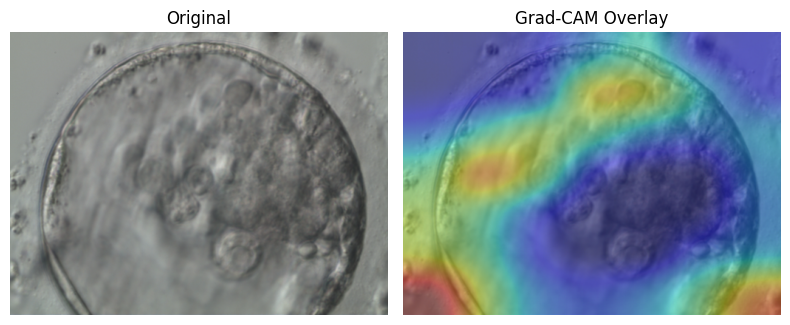

In [3]:
from src.utils.grad_cam import generate_gradcam_for_image

# Use the same sample_path from the previous cell
print("Using sample image:", sample_path)

gradcam_path = generate_gradcam_for_image(
    sample_path,
    model_name="efficientnet_b0",
)

print("Grad-CAM saved to:", gradcam_path)

# Load and show original + Grad-CAM side by side
gradcam_img = Image.open(gradcam_path)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(np_img)
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(gradcam_img)
axes[1].set_title("Grad-CAM Overlay")
axes[1].axis("off")

plt.tight_layout()
plt.show()

Loaded figures:
 - D:\Projects\ivf-embryo-grading\reports\figures\accuracy_efficientnet_b0.png
 - D:\Projects\ivf-embryo-grading\reports\figures\loss_efficientnet_b0.png
 - D:\Projects\ivf-embryo-grading\reports\figures\confusion_matrix_efficientnet_b0.png
 - D:\Projects\ivf-embryo-grading\reports\figures\gradcam_efficientnet_b0.png


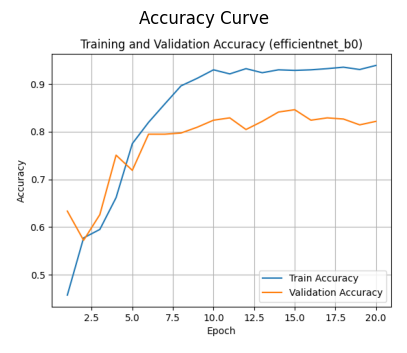

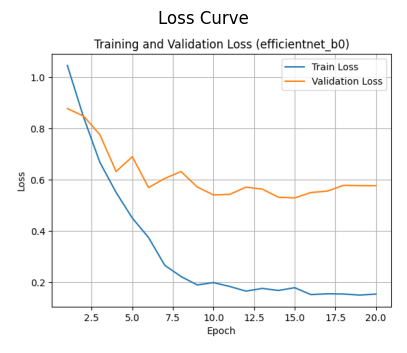

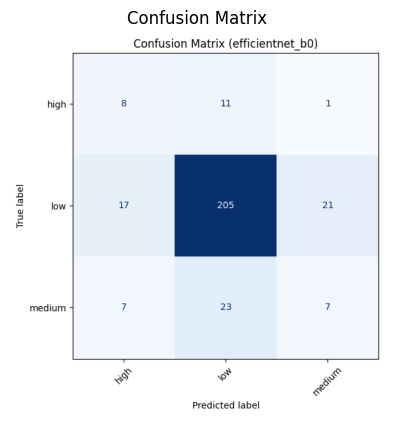

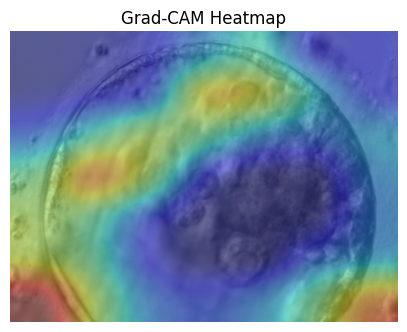

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt

from src.config import FIGURES_DIR

acc_path = os.path.join(FIGURES_DIR, "accuracy_efficientnet_b0.png")
loss_path = os.path.join(FIGURES_DIR, "loss_efficientnet_b0.png")
cm_path = os.path.join(FIGURES_DIR, "confusion_matrix_efficientnet_b0.png")
gradcam_path = os.path.join(FIGURES_DIR, "gradcam_efficientnet_b0.png")

def show_image(path, title):
    img = Image.open(path)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

print("Loaded figures:")
print(" -", acc_path)
print(" -", loss_path)
print(" -", cm_path)
print(" -", gradcam_path)

show_image(acc_path, "Accuracy Curve")
show_image(loss_path, "Loss Curve")
show_image(cm_path, "Confusion Matrix")
show_image(gradcam_path, "Grad-CAM Heatmap")